In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from itertools import product
from random import shuffle
from tqdm import tqdm
import time

from KNN_Embeddings import *

(89996, 512)


/home/pmao/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.7562674094707521
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1338
           1       0.94      0.99      0.97       847
           2       0.44      0.77      0.56       339
           3       0.77      0.84      0.81       634
           4       0.81      0.56      0.67      1035
           5       0.61      0.62      0.61       592
           6       0.80      0.68      0.74       741
           7       0.30      0.39      0.34       421
           8       0.80      0.70      0.74      1233

    accuracy                           0.76      7180
   macro avg       0.71      0.73      0.71      7180
weighted avg       0.78      0.76      0.76      7180

Confusion Matrix:
[[1310    4    3    0   15    3    3    0    0]
 [   3  841    0    0    2    0    0    1    0]
 [   0    1  262    4    0   46    0   24    2]
 [   0    1   45  534    2    0   12    3   37]
 [  83   43   20   29  583   61  

In [2]:
# Feature normalization
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, Dataset
import random

class TripletDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        # Ensure labels are in a flat, 1D array
        if labels.dim() > 1:
            labels = labels.view(-1)
        self.labels = labels
        self.labels_set = set(labels.numpy())
        self.label_to_indices = {label: np.where(labels.numpy() == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):
        anchor = self.embeddings[index]
        anchor_label = self.labels[index].item()
        positive_index = index
        while positive_index == index:
            positive_index = random.choice(self.label_to_indices[anchor_label])
        negative_label = random.choice(list(self.labels_set - {anchor_label}))
        negative_index = random.choice(self.label_to_indices[negative_label])
        positive = self.embeddings[positive_index]
        negative = self.embeddings[negative_index]
        return anchor, positive, negative, anchor_label, negative_label

    def __len__(self):
        return len(self.embeddings)


# Create a scaler object
scaler = StandardScaler()

# Fit on training data and transform both training and test data
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TripletDataset(X_train_tensor, y_train_tensor)
test_dataset = TripletDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)



## Shared Sub Network

In [3]:
class SharedSubNet(nn.Module):
    def __init__(self):
        super(SharedSubNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(64, 50, kernel_size=1, stride=1)  # Using 1x1 convolutions
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

## Divide and Encode module

In [4]:
class DivideAndEncode(nn.Module):
    def __init__(self, num_slices=50, bits_per_slice=1, num_bits=10):
        super(DivideAndEncode, self).__init__()
        self.num_slices = num_slices
        self.bits_per_slice = bits_per_slice
        self.fc_layers = nn.ModuleList([nn.Linear(num_slices, bits_per_slice) for _ in range(num_bits)])

    def forward(self, x):
        outputs = []
        for fc in self.fc_layers:
            out = F.sigmoid(fc(x))  # Applying sigmoid to restrict output to [0, 1]
            out = self.piecewise_threshold(out)
            outputs.append(out)
        return torch.cat(outputs, dim=1)

    def piecewise_threshold(self, s, epsilon=0.05):
        return torch.where(s < 0.5 - epsilon, torch.zeros_like(s),
                           torch.where(s > 0.5 + epsilon, torch.ones_like(s), s))


## Triplet Ranking Loss

In [5]:
class TripletRankingLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletRankingLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)  # L2 squared
        distance_negative = (anchor - negative).pow(2).sum(1)  # L2 squared
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()


## Training

In [6]:
class IntegratedModel(nn.Module):
    def __init__(self, num_bits):
        super(IntegratedModel, self).__init__()
        self.shared_subnet = SharedSubNet()
        self.divide_and_encode = DivideAndEncode(num_slices=50, bits_per_slice=1, num_bits=num_bits)
        self.fc = nn.Linear(24, 512)  # Adjusted input size
        self.relu = nn.ReLU()
        self.final_fc = nn.Linear(512, num_bits)  # Output bits as the number of output features

    def forward(self, x):
        x = self.shared_subnet(x)
        print("Shape after SharedSubNet:", x.shape)
        x = self.divide_and_encode(x)
        print("Shape after DivideAndEncode:", x.shape)
        x = self.fc(x)
        x = self.relu(x)
        x = self.final_fc(x)
        x = torch.tanh(x)
        x = F.normalize(x, p=2, dim=1)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Model, optimizer, and loss
model = IntegratedModel(input_dim=X_train_tensor.shape[1], num_bits=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_func = TripletRankingLoss()

start_time = time.time()
for epoch in range(20):
    model.train()
    total_loss = 0.0
    for anchor, positive, negative, _, _ in train_loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        anchor_output = model(anchor)
        positive_output = model(positive)
        negative_output = model(negative)
        loss = loss_func(anchor_output, positive_output, negative_output)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')



Epoch 1, Loss: 0.2936644152537592
Epoch 2, Loss: 0.22507329198300796
Epoch 3, Loss: 0.20672036539273392
Epoch 4, Loss: 0.1947055954298146
Epoch 5, Loss: 0.18382455096047243
Epoch 6, Loss: 0.17750082630200767
Epoch 7, Loss: 0.17037807278965242
Epoch 8, Loss: 0.1645948319896452
Epoch 9, Loss: 0.16116458786004134
Epoch 10, Loss: 0.15333731655844282
Epoch 11, Loss: 0.1514208103479141
Epoch 12, Loss: 0.14477303403932085
Epoch 13, Loss: 0.14522269850314806
Epoch 14, Loss: 0.139754612721614
Epoch 15, Loss: 0.13304877354397407
Epoch 16, Loss: 0.1321394022689191
Epoch 17, Loss: 0.1263675721681279
Epoch 18, Loss: 0.12434917309221513
Epoch 19, Loss: 0.12147423750691132
Epoch 20, Loss: 0.11804157531573341


In [7]:
epoch_duration = time.time() - start_time
print(f"Training time for Epoch: {epoch_duration} seconds")

Training time for Epoch: 325.022522687912 seconds


## KNN on hashed embeddings

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for anchor, _, _, label_a, _ in test_loader:  # Correctly unpack all elements
            anchor = anchor.to(device)
            output = model(anchor)
            embeddings.append(output.cpu())
            labels.append(label_a)
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels

# Ensure model and device are defined and properly initialized
# Example: model = DPSH(input_dim=X_train.shape[1], num_bits=48).to(device)
# and device is defined like device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract hash codes
train_codes, train_labels = evaluate_model(model, train_loader, device)
test_codes, test_labels = evaluate_model(model, test_loader, device)

# Classification with KNN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(train_codes, train_labels)
predictions = knn.predict(test_codes)
y_pred_proba = knn.predict_proba(test_codes)

print(classification_report(test_labels, predictions))

# Binarize the labels for a one-vs-rest computation
y_test_binarized = label_binarize(test_labels, classes=np.unique(train_labels))  # Updated to use `test_labels`

# Calculate the average precision for each class
average_precisions = []
for i in range(y_test_binarized.shape[1]):  # iterate over classes
    average_precisions.append(average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i]))

# Compute the mean of the average precisions
map_score = np.mean(average_precisions)
print(f'Mean Average Precision (MAP): {map_score}')

print(confusion_matrix(test_labels, predictions))


              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1338
           1       0.94      1.00      0.96       847
           2       0.37      0.58      0.46       339
           3       0.90      0.84      0.87       634
           4       0.90      0.75      0.82      1035
           5       0.62      0.74      0.67       592
           6       0.84      0.75      0.79       741
           7       0.43      0.47      0.45       421
           8       0.86      0.75      0.80      1233

    accuracy                           0.81      7180
   macro avg       0.76      0.76      0.75      7180
weighted avg       0.82      0.81      0.81      7180

Mean Average Precision (MAP): 0.7228379002814251
[[1315    2    3    0    9    9    0    0    0]
 [   2  843    0    0    1    1    0    0    0]
 [   0    1  198    1    0  112    1   23    3]
 [   0    1   60  535    1    1   11    6   19]
 [  65   53    6    0  780   15   15   75   26]
 [   0

/tmp/ipykernel_283430/3427141356.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + classes)
/tmp/ipykernel_283430/3427141356.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + classes)


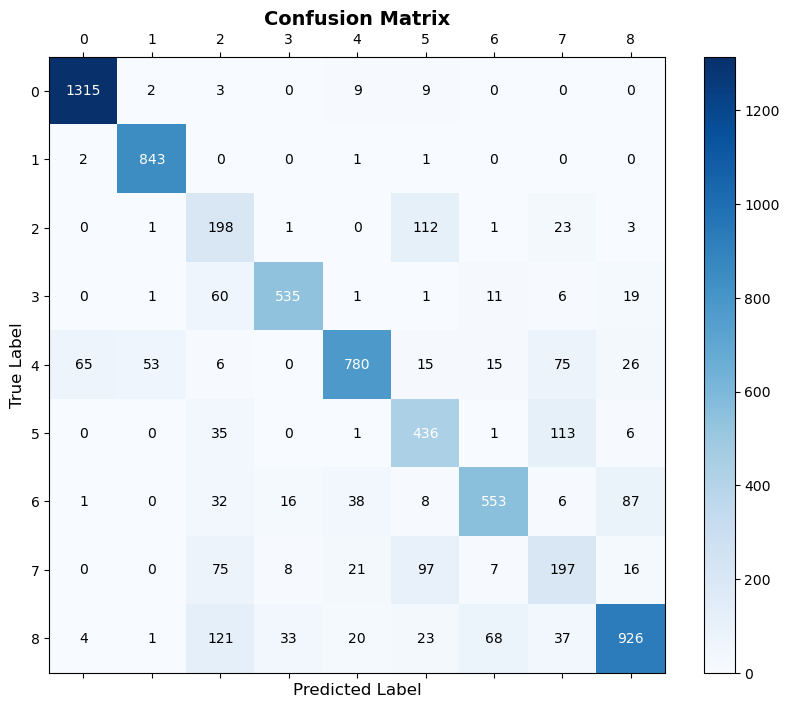

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Provided confusion matrix
confusion_matrix_data = np.array([
    [1315, 2, 3, 0, 9, 9, 0, 0, 0],
    [2, 843, 0, 0, 1, 1, 0, 0, 0],
    [0, 1, 198, 1, 0, 112, 1, 23, 3],
    [0, 1, 60, 535, 1, 1, 11, 6, 19],
    [65, 53, 6, 0, 780, 15, 15, 75, 26],
    [0, 0, 35, 0, 1, 436, 1, 113, 6],
    [1, 0, 32, 16, 38, 8, 553, 6, 87],
    [0, 0, 75, 8, 21, 97, 7, 197, 16],
    [4, 1, 121, 33, 20, 23, 68, 37, 926]
])

# Visualizing the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(confusion_matrix_data, cmap=plt.cm.Blues)  # Using a color map that highlights differences
plt.colorbar(cax)

# Setting axis labels
classes = list(range(9))  # Assuming the classes are labeled from 0 to 8
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)

# Adding text annotations for each cell with the respective counts
for (i, j), val in np.ndenumerate(confusion_matrix_data):
    ax.text(j, i, f'{val}', ha='center', va='center', color='white' if val > 200 else 'black')

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

plt.show()
